In [ ]:
! pip install -U langchain openai chromadb pypdfium2 open_clip pillow

## Load

In [3]:
import base64
import os
import uuid
from io import BytesIO

import chromadb
import numpy as np
import pypdfium2 as pdfium
from IPython.display import HTML, display
from PIL import Image, Image as _PILImage

from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.schema.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

In [4]:
# File
fpath = "/Users/rlm/Desktop/Eval_Sets/multi_modal_presentations/DDOG/"
fname = "DDOG_Q3_earnings_deck.pdf"

In [23]:
def get_images(fpath, fname):
    """
    Get PIL images from PDF pages
    """
    pdf = pdfium.PdfDocument(fpath + fname)
    n_pages = len(pdf)
    pil_images = []
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        bitmap = page.render(scale=1, rotation=0, crop=(0, 0, 0, 0))
        pil_image = bitmap.to_pil()
        pil_images.append(pil_image)
        pil_image.save(fpath + "img_%s.jpg" % str(page_number + 1), format="JPEG")
    return pil_images

pil_images = get_images(fpath, fname)

In [45]:
def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def convert_to_base64(pil_image):
    """
    Base64 encoded strings
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    # Needed to avoid OAI BadRequestError (root cause is unclear)
    img_str = resize_base64_image(img_str, size=(1280,720))
    return img_str


images_base_64 = [convert_to_base64(i) for i in pil_images]


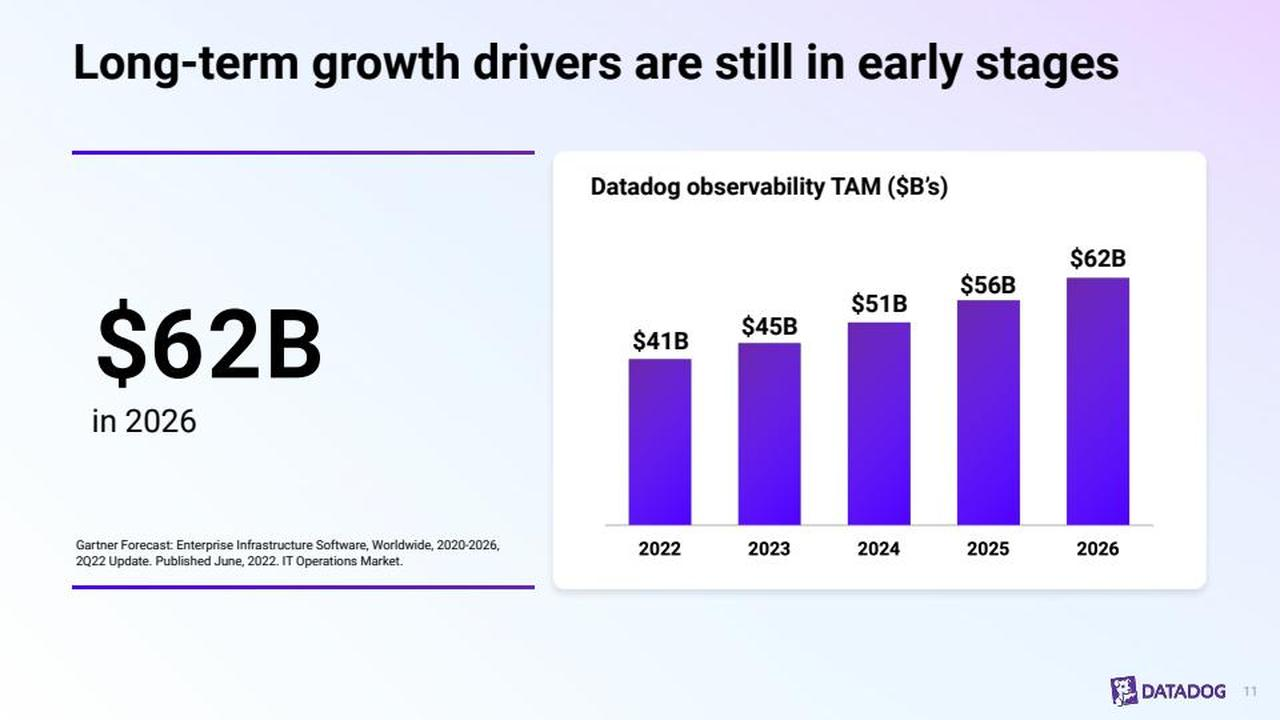

In [46]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


i = 10
plt_img_base64(images_base_64[i])

## Summarize Images

In [26]:
def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(img_base64_list):
    """
    Generate summaries and base64 encoded strings for images
    img_base64_list: Base64 encoded images
    """

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for i, base64_image in enumerate(img_base64_list):
        
        image_summaries.append(image_summarize(base64_image, prompt))

    return image_summaries


# Image summaries
image_summaries = generate_img_summaries(images_base_64)

## Make Retriever

### MV Retriever

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary): 

* Store the raw images in the `docstore`.
* Store the image summaries in the `vectorstore` for semantic retrieval.

In [52]:
def create_multi_vector_retriever(vectorstore, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    add_documents(retriever, image_summaries, images)

    return retriever

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="multi-modal-rag-deck", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    image_summaries,
    images_base_64,
)

### Multi modal embeddings

In [5]:
# Create chroma
vectorstore_mmembd = Chroma(
    collection_name="multi-modal-rag-deck-mmembd",
    embedding_function=OpenCLIPEmbeddings(),
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(fpath, image_name)
        for image_name in os.listdir(fpath)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore_mmembd.add_images(uris=image_uris)

# Make retriever
retriever_mmembd = vectorstore_mmembd.as_retriever()

## RAG

In [77]:
import io
import re

from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            # Note: OAI throws bad request error on retrieval when image size is 
            # too large. The behavior is not obvious (images << 20MB threshold) 
            # and needs further investigation. For now, empirically tuning the 
            # image size does work, but a systematic solution is needed.
            doc = resize_base64_image(doc, size=(1280,720)) 
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict,num_images=1):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        # Restrict prompt to num_images
        for image in data_dict["context"]["images"][:num_images]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an analyst tasked with answering questions about visual content.\n"
            "You will be give a set of image(s) from a slide deck / presentation.\n"
            "Use this information to answer the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, 
                       model="gpt-4-vision-preview", 
                       max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)
chain_multimodal_rag_mmembd = multi_modal_rag_chain(retriever_mmembd)

## Test retrieval


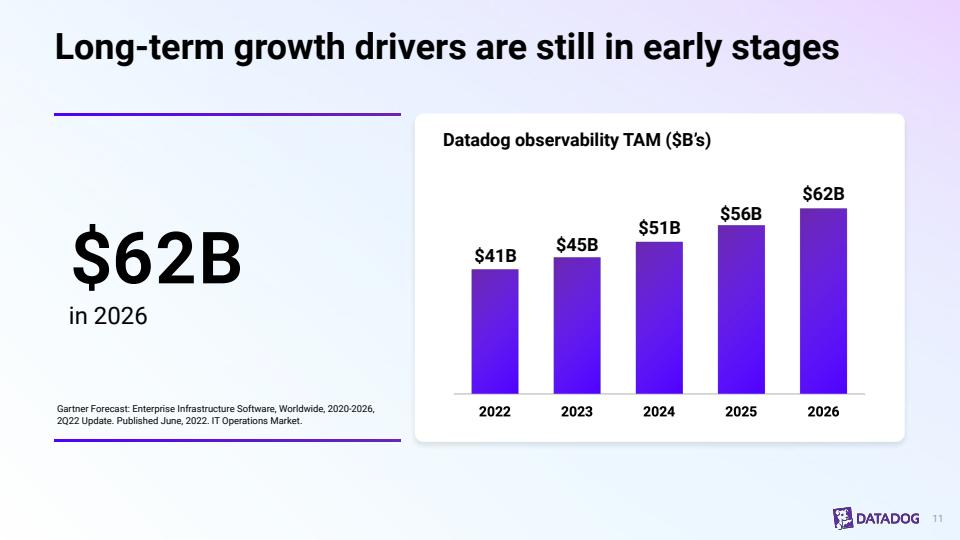

In [49]:
docs = retriever_mmembd.get_relevant_documents(
    "What is the projected TAM over time for observability?"
)
plt_img_base64(docs[0].page_content)


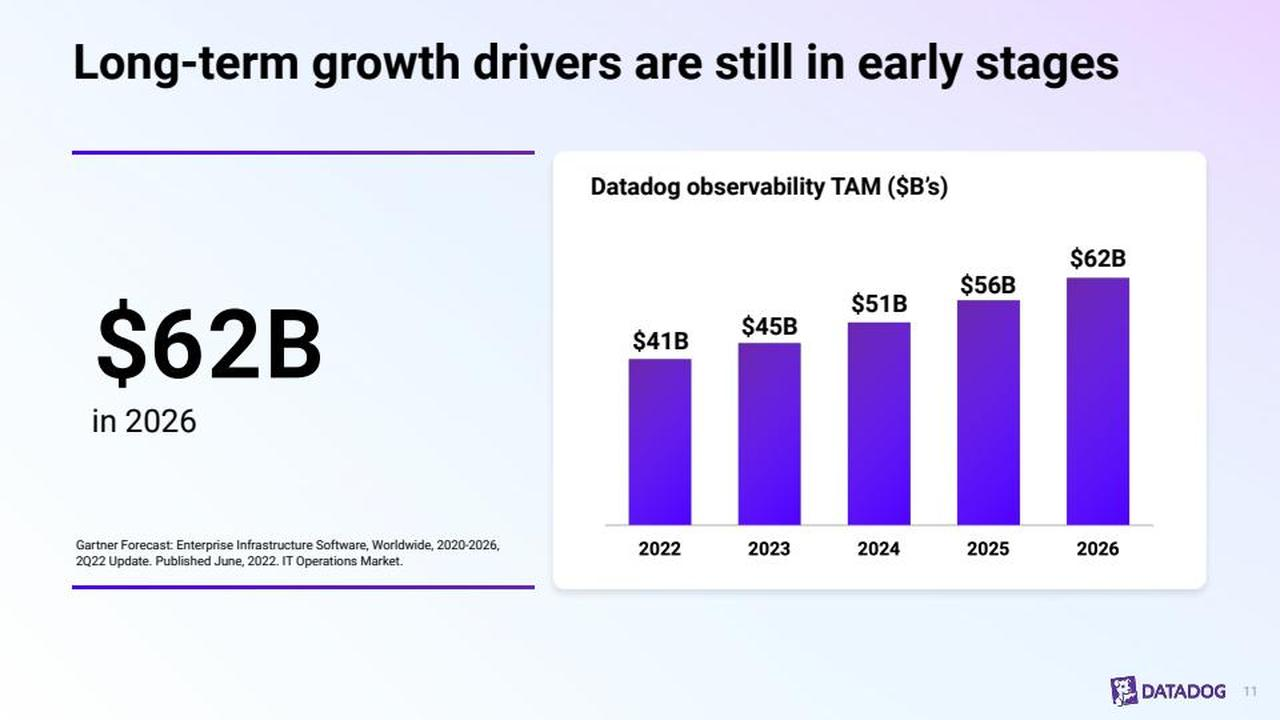

In [54]:
docs = retriever_multi_vector_img.get_relevant_documents(
    "What is the projected TAM over time for observability?"
)
plt_img_base64(docs[0])

## Test inference

In [16]:
chain_multimodal_rag_mmembd.invoke(
    "What is the projected TAM over time for observability?"
)

"Based on the information provided in the first image, the projected Total Addressable Market (TAM) for observability, as it pertains to Datadog, is expected to grow over time. Here is the projected TAM for observability from 2022 to 2026:\n\n- 2022: $41 billion\n- 2023: $45 billion\n- 2024: $51 billion\n- 2025: $56 billion\n- 2026: $62 billion\n\nThis data suggests a steady increase in the TAM for observability, indicating a growing market opportunity for companies like Datadog that offer observability solutions. As a financial analyst, this trend could be seen as a positive indicator for the future revenue potential of companies operating in this space. If Datadog is well-positioned to capture a significant share of this market, it could be a favorable factor in an investment decision. However, it's important to consider other factors such as competition, market penetration, product offerings, and overall company performance when making investment recommendations."

In [55]:
chain_multimodal_rag.invoke("What is the projected TAM over time for observability?")

"Based on the first image provided, the projected Total Addressable Market (TAM) for observability is expected to grow over time. Here are the figures for the projected TAM for observability from 2022 to 2026:\n\n- In 2022, the TAM is $41 billion.\n- In 2023, the TAM is projected to increase to $45 billion.\n- In 2024, the TAM is expected to grow to $51 billion.\n- In 2025, the TAM is forecasted to be $56 billion.\n- By 2026, the TAM is anticipated to reach $62 billion.\n\nThis data suggests a steady growth trajectory for the observability market. As a financial analyst, if you are considering investment advice related to companies operating within this space, it would be prudent to look at companies that are well-positioned to capture a share of this growing market. Companies that are innovating in observability and have a strong product offering could stand to benefit from this increasing market size. However, it's also important to consider other factors such as the competitive land

See [trace](https://smith.langchain.com/public/21c61c87-2bdd-4c38-9967-b9df9f5549fb/r).

In [42]:
chain_multimodal_rag.invoke("What are the components of the Datadog platform?")

"The components of the Datadog platform, as depicted in the provided images, can be categorized into several key areas:\n\n1. **Infrastructure Monitoring**:\n   - Containers\n   - Serverless\n   - Network Performance Monitoring\n   - Network Device Monitoring\n   - Cloud Cost Management\n\n2. **Application Performance Monitoring**:\n   - Distributed Tracing\n   - Error Tracking\n   - Continuous Profiler\n   - Database Monitoring\n   - Universal Service Monitoring\n   - Data Streams Monitoring\n\n3. **Digital Experience Monitoring**:\n   - Synthetics\n   - Browser Real User Monitoring\n   - Session Replay\n   - Mobile Real User Monitoring\n   - Mobile App Testing and Monitoring\n\n4. **Log Management**:\n   - Observability Pipelines\n   - Sensitive Data Scanner\n   - Audit Trail\n   - Log Forwarding\n\n5. **Security**:\n   - Cloud Security Management\n   - Application Security Management\n   - Cloud SIEM\n   - Application Vulnerability Management\n\n6. **Developer Experience**:\n   - CI

See [trace](https://smith.langchain.com/public/dbe9e2b5-d21c-41a2-b037-60573035dbe9/r).

In [46]:
chain_multimodal_rag.invoke("How many total customers does Datadog have?")

'Based on the information provided in the images, Datadog has approximately 26,800 total customers as of the latest data point presented.'

See [trace](https://smith.langchain.com/public/fbaf39df-abd4-4258-bd61-a1ced4073774/r).

## Eval

In [63]:
### TODO: Replace with public dataset

import uuid

import pandas as pd
from langsmith import Client

# Read
df = pd.read_csv(
    "/Users/rlm/Desktop/Eval_Sets/multi_modal_presentations/multi_modal_presentations.csv"
)

# Dataset
client = Client()
dataset_name = "Multi-Modal-Eval-v2"
dataset = client.create_dataset(dataset_name=dataset_name)

# Populate dataset
for _, row in df.iterrows():
    # Get Q, A
    q = row["Question"]
    a = row["Answer"]

    # Use the values in your function
    client.create_example(
        inputs={"question": q}, outputs={"answer": a}, dataset_id=dataset.id
    )

In [78]:
import uuid
from functools import partial

from langsmith.client import Client

from langchain_benchmarks.rag import get_eval_config
from langchain.smith import RunEvalConfig

eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)


def run_eval(chain, eval_run_name):
    """
    Run eval
    """
    client = Client()
    test_run = client.run_on_dataset(
        ### TODO: Replace with public dataset
        dataset_name="Multi-Modal-Eval-v2",
        llm_or_chain_factory=lambda: (lambda x: x["question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=eval_run_name,
    )


# Experiments
chain_map = {
    "multi_modal_mvretriever_gpt4v": chain_multimodal_rag,
    "multi_modal_mmembd_gpt4v": chain_multimodal_rag_mmembd,
}

run_id = str(uuid.uuid4())
for project_name, chain in chain_map.items():
    run_eval(chain, project_name + "_" + run_id)

View the evaluation results for project 'multi_modal_mvretriever_gpt4v_04c68c44-38aa-4354-878b-e63b7ba61ff9' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/554ce691-581a-41d6-8a2a-2f497fdffc47?eval=true

View all tests for Dataset Multi-Modal-Eval-v2 at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/3f16e60b-8e21-49f2-bf98-8742a968e9f3
[------------------->                              ] 4/10

Error Type: BadRequestError, Message: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'image_parse_error'}}


[------------------------------------------------->] 10/10
 Eval quantiles:
                                          inputs.question  \
count                                                  10   
unique                                                 10   
top     How many customers with ARR > $100k did Datado...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        feedback.COT Contextual Accuracy  \
count                           9.000000   
unique                               NaN   
top                                  NaN   
freq           

```
 BadRequestError, Message: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'image_parse_error'}
                                              ```